<a href="https://colab.research.google.com/github/BeytullahYayla/Aerial-Image-Segmentation-With-Unet/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

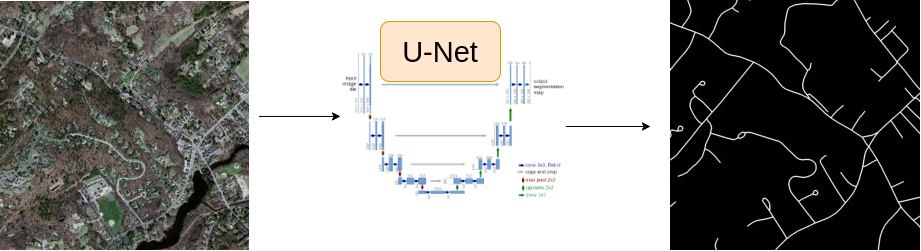

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE="/content/Road_seg_dataset/train.csv"
DATA_DIR="/content/Road_seg_dataset/"

DEVICE="cuda"
LR=0.03

BATCH_SIZE=8
IMG_SIZE=512
ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'
EPOCHS=25




In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

In [ ]:
idx=10
row=df.iloc[idx]



image_path=DATA_DIR+row.images
mask_path=DATA_DIR+row.masks

image_path

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255




In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,val_df=train_test_split(df,test_size=0.25,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentation):
    self.df=df
    self.augmentation=augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row=df.iloc[idx]

    image_path=DATA_DIR+row.images
    mask_path=DATA_DIR+row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,-1)

    if self.augmentation:
      data=self.augmentation(image=image,mask=mask)
      image=data["image"]
      mask=data["mask"]

    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask



In [ ]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(val_df,get_valid_augs())

In [ ]:
print(f"Length of trainset:{len(trainset)}")
print(f"Length of validset:{len(validset)}")

In [ ]:
idx=20
image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=DataLoader(validset,BATCH_SIZE)

In [ ]:
print(f'Total number of batches in trainLoader:{len(train_loader)}')
print(f'Total number of batches in valid_loader:{len(valid_loader)}')

In [ ]:
for image,mask in train_loader:
  print(f'Dimension of image in one batch of train loader{image.shape}')
  print(f'Dimension of mask in one batch of train loader{mask.shape}')

  break

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss


from torch import nn

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.backbone=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self,image,mask=None):
    logits=self.backbone(image)



    if mask!=None:
      return logits,DiceLoss(mode="binary")(logits,mask)+nn.BCEWithLogitsLoss()(logits,mask)

    return logits

In [ ]:
model=SegmentationModel()


# Task 7 : Create Train and Validation Function 

In [ ]:
from torch.nn.modules import loss
def train_func(data_loader,model,optimizer):

  model.train()#Turn on Dropout,BatchNorm etc

  total_loss=0.0

  for images,masks in tqdm(data_loader):

     

    optimizer.zero_grad()
    logits,loss=model(images,masks)

    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)


In [ ]:
from torch.nn.modules import loss
def eval_func(data_loader,model,optimizer):

  model.eval()#Turn off Droput,BatchNorm etc.

  total_loss=0.0

  with torch.no_grad():

    for images,masks in tqdm(data_loader):

     


      
      logits,loss=model(images,masks)
      total_loss+=loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_func(train_loader,model,optimizer)
  valid_loss=eval_func(valid_loader,model,optimizer)

  if valid_loss<best_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("Saved model")
    best_loss=valid_loss

  print(f"Epoch {i+1}, Training loss:{train_loss}  Validation_loss:{valid_loss}")

100%|██████████| 7/7 [00:33<00:00,  4.82s/it]


Saved model
Epoch 1, Training loss:0.7669876500179893  Validation_loss:0.8109240787369865


100%|██████████| 7/7 [00:33<00:00,  4.76s/it]


Epoch 2, Training loss:0.7651594061600534  Validation_loss:0.8196797796658107


100%|██████████| 7/7 [00:33<00:00,  4.75s/it]


Epoch 3, Training loss:0.7377308732584903  Validation_loss:0.9064627289772034


100%|██████████| 7/7 [00:32<00:00,  4.71s/it]


Saved model
Epoch 4, Training loss:0.7121826755373102  Validation_loss:0.7334714361599514


100%|██████████| 7/7 [00:33<00:00,  4.83s/it]


Epoch 5, Training loss:0.7149894551226967  Validation_loss:0.8000731297901699


 42%|████▏     | 8/19 [03:15<04:27, 24.36s/it]

# Task 9 : Inference

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

